# Keck 2 Polarization Model

Here we create a model of the Keck 2 telescope + AO Bench to determine the transformation of the generally polarized field through the system. We've loaded a poke.Rayfront generated on a windows maching using a Zemax OpticStudio (ZOS) raytrace of the observatory.

In [2]:
from poke.writing import read_serial_to_rayfront
pth = 'rayfronts/k2_acam_64rays_633nm.msgpack'
rf = read_serial_to_rayfront(pth)

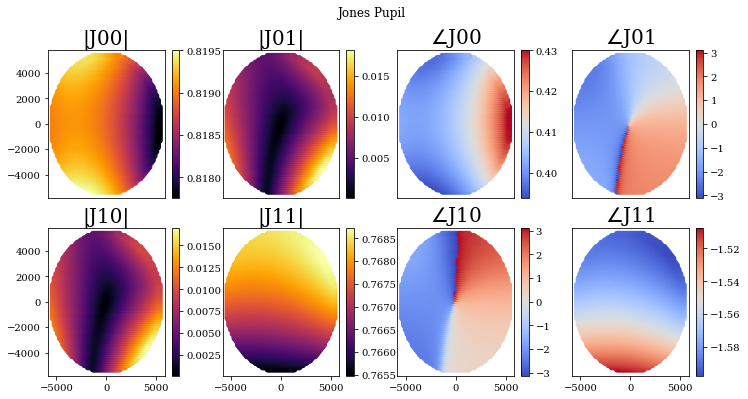

In [3]:
import poke.plotting as plot
plot.jones_pupil(rf)

## More realistic Coatings
I used a dummy coating of n = 0.4 + 7i on the prior coating just to generate something but we should model the observatory more realistically. What materials do we need?

**The Telescope**
- M1: https://www.keckobservatory.org/keeping_keck_telescopes_shiny/ claims that the primary mirror is aluminum, maybe it's a safe bet to just use Al for the observatory optics?

In [4]:
from poke.poke_math import np

# Jones pupil parameters for this raytrace
a = np.array([0.9781476007,-0.2079116908, 0.0000000000])
ap = np.array([0.9851019261,-0.1719714953, 0.0000000000]) # ray from edge of pupil
x = np.cross(a,ap)
x /= np.linalg.norm(x)

# lambda = 633nm
n_Al = 1.4495 + 1j*7.5387
n_Ag = 0.056206 + 1j*4.2776
n_ZD = 1.5403
n_SiO2 = 1.4570
n_MgF2 = 1.3770

al_coat = [(n_Ag,120e-9),(n_ZD)]
ag_coat = [(n_MgF2,54e-9),(n_Ag,120e-9),(n_ZD)]

# set up surfaces
m1 = {'coating':al_coat,'surf':1,'mode':'reflect'} # Al
m2 = {'coating':al_coat,'surf':2,'mode':'reflect'} # Al
m3 = {'coating':al_coat,'surf':4,'mode':'reflect'} # Al

k1 = {'coating':ag_coat,'surf':10,'mode':'reflect'} # Al
k2 = {'coating':ag_coat,'surf':13,'mode':'reflect'} # Opticoat protected silver or FSS99 Denton
k3 = {'coating':ag_coat,'surf':16,'mode':'reflect'} # Al

tt = {'coating':ag_coat,'surf':20,'mode':'reflect'} # remainder are Opticoat or FSS99 Denton
o1 = {'coating':ag_coat,'surf':25,'mode':'reflect'}
pu = {'coating':ag_coat,'surf':30,'mode':'reflect'}
o2 = {'coating':ag_coat,'surf':33,'mode':'reflect'}
di = {'coating':ag_coat,'surf':36,'mode':'reflect'}

sod = {'coating':ag_coat,'surf':40,'mode':'reflect'}
ifm = {'coating':ag_coat,'surf':43,'mode':'reflect'}
afm = {'coating':ag_coat,'surf':46,'mode':'reflect'}


rf.surfaces = [m1,m2,m3,k1,k2,k3,tt,o1,pu,o2,di,sod,ifm,afm]
rf.compute_jones_pupil(aloc=a,exit_x=x)

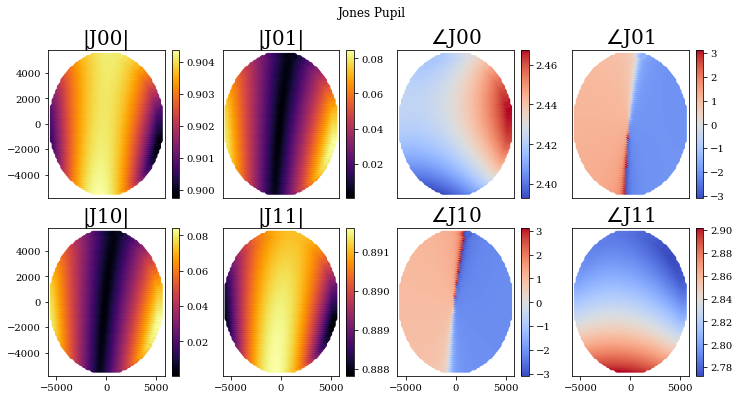

In [49]:
plot.jones_pupil(rf)

## PSF Analysis
Let's get hexagonal

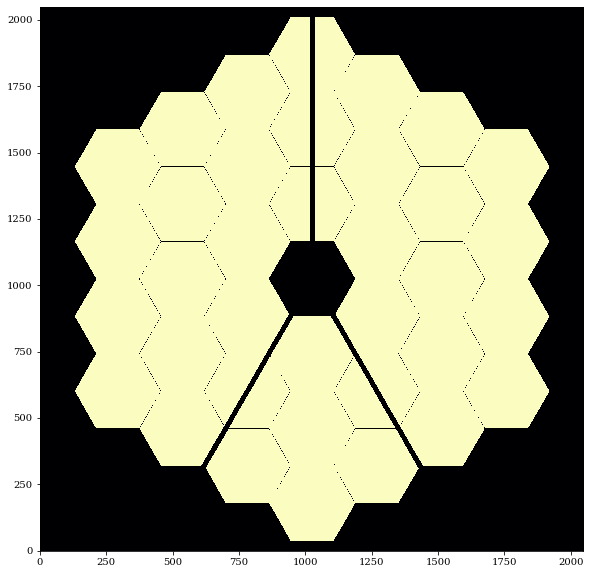

In [24]:
from prysm import (
    coordinates,
    geometry,
    segmented,
    polynomials,
    propagation,
    wavelengths
)
import matplotlib.pyplot as plt

x, y = coordinates.make_xy_grid(2048, diameter=10.950)
dx = x[0,1] - x[0,0]

cha = segmented.CompositeHexagonalAperture(x,y,3,1.5,0.007,exclude=(0,))
m1 = geometry.spider(1, .1, x, y, rotation=-120)
m2 = geometry.spider(1, .1, x, y, rotation=-60)
m3 = geometry.spider(1, .1, x, y, rotation=90)
spider = m1&m2&m3

pupil_mask = cha.amp & spider
plt.figure(figsize=[10,10])
plt.imshow(pupil_mask)
plt.show()

[1.59834299e-06]
[1.54828625e-06]
[1.68968646e-06]
[2.4064947e-06]


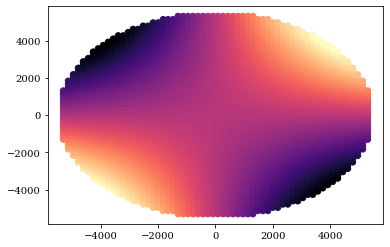

In [44]:
# Fit the jones pupil data to zernike polynomials
xd,yd = rf.xData[0,0],rf.yData[0,0]
r,t = np.sqrt(xd**2 + yd**2),np.arctan2(yd,xd)
nms = [polynomials.noll_to_nm(j) for j in range(1,11)]
modes = (list(polynomials.zernike_nm_sequence(nms,r,t)))
modes = np.array([mode for mode in modes])
plt.scatter(xd,yd,c=modes[4])

def make_jones_functional(jones_pupil,modes):

    c = np.linalg.lstsq(modes.T,jones_pupil,rcond=None)
    print(c[1])

    return c[0]
which = -1
cxx = make_jones_functional(rf.jones_pupil[which][...,0,0],modes)
cxy = make_jones_functional(rf.jones_pupil[which][...,0,1],modes)
cyx = make_jones_functional(rf.jones_pupil[which][...,1,0],modes)
cyy = make_jones_functional(rf.jones_pupil[which][...,1,1],modes)

In [45]:
rs,ts = coordinates.cart_to_polar(x,y)
modes_reg = np.complex128(list(polynomials.zernike_nm_sequence(nms,rs,ts)))
# plt.imshow(modes_reg[4]*pupil_mask)

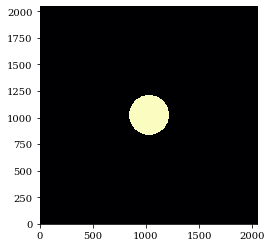

In [54]:
A = geometry.circle(1,rs)

# Now fit to the data
jxx = polynomials.sum_of_2d_modes(modes_reg,cxx)
jxy = polynomials.sum_of_2d_modes(modes_reg,cxy)
jyx = polynomials.sum_of_2d_modes(modes_reg,cyx)
jyy = polynomials.sum_of_2d_modes(modes_reg,cyy)
plt.imshow(np.angle(jyy)*A)

In [47]:
cxx

array([-6.84704743e-01+5.90430107e-01j, -1.20442297e-06-1.42957439e-06j,
       -7.04717616e-07-8.30489365e-07j,  3.43085056e-11+9.21465522e-12j,
       -4.74177894e-12+5.39851519e-13j, -1.20749349e-10-1.81510183e-10j,
       -4.03465606e-16+1.81910323e-16j,  1.09338930e-16-4.73096265e-17j,
       -8.22843845e-16+1.89671630e-16j,  2.13291104e-16-1.88497201e-16j])